# Visualize Code Generation Results - Reflection Results

1. 15 small language models (SLMs) were tested on 4 code generation datasets.
2. Metric used - Pass@1
3. This notebooks load raw results, visualizes them by dataset, and ranks the models based on their average performance.
4. Alternatively, it applies the MinMaxScaler to normalize the results and then rank SLMs.

__Candiates for removal__ for the reflection workflow cycle:
* Mistral 7B (lowest results)
* Mistral codestral_mamba - discontinued by Mistral AI because API call to list all the available models doesn't contain this one, only the 22B codstral model and the codestral embeddings model.
* Solar-10.7B (10.7B model, but low results).
* Phixtral-4x2_8 (duplicates the results of Phixtral-2x2_8).
* Mistral Nemo (12B model - largest among all, but it performs at the level of 7~8B models). SINCE CODESTRAL_MAMBA IS DISCONTINUED, I MIGHT AS WELL KEEP NEMO

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PART 1. Load Results and Scale the Four Datasets

In [33]:
# load all data
file = '/Users/andrew/Documents/04_git/code-generation/0_documents/2_docs/indiv_model_results_20250529.xlsx'
sheet_names = ['HumanEval_Reflection', 'BigCode_Reflection', 'MBPP_Reflection', 'LBPP_Reflection',]
res_raw = dict()
for sheet_name in sheet_names:
    res_raw[sheet_name] = pd.read_excel( file, sheet_name=sheet_name )
print('Datasets:', ', '.join(list(res_raw.keys())))
print(res_raw['HumanEval_Reflection'].shape)
res_raw['HumanEval_Reflection']

Datasets: HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(12, 17)


,#,dataset,prompt,cleaning,temperature,top_p,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
0,1,humanEval_reflect,basic_prompt,raw,1,1,0.134146,0.000000,0.000000,0.109756,0.347561,0.445122,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,humanEval_reflect,basic_prompt,partial,1,1,0.286585,0.493902,0.554878,0.707317,0.713415,0.737805,0.817073,0.829268,0.756098,0.768293,0.682927
2,3,humanEval_reflect,basic_prompt,full,1,1,0.310976,0.506098,0.554878,0.701220,0.719512,0.743902,0.823171,0.835366,0.750000,0.762195,0.682927
3,4,humanEval_reflect,basic_prompt,full_light,1,1,0.292683,0.493902,0.634878,0.707317,0.713415,0.737805,0.817073,0.829968,0.756098,0.768293,0.682927
4,5,humanEval_reflect,prompt,raw,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.140244,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,humanEval_reflect,prompt,partial,1,1,0.554878,0.573171,0.481707,0.786585,0.731707,0.713415,0.792683,0.786585,0.128049,0.701220,0.634146
6,7,humanEval_reflect,prompt,full,1,1,0.573171,0.713659,0.512195,0.780488,0.725610,0.725610,0.829268,0.823171,0.756098,0.808878,0.634146
7,8,humanEval_reflect,prompt,full_light,1,1,0.579268,0.713659,0.512195,0.817766,0.731707,0.771807,0.845568,0.823171,0.756098,0.804878,0.634146
8,9,humanEval_reflect,full_prompt,raw,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.164634,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,humanEval_reflect,full_prompt,partial,1,1,0.530488,0.554878,0.542683,0.701220,0.777805,0.701220,0.829268,0.810976,0.207317,0.701220,0.487805


In [34]:
# select 15 SLM model columns and add index for convenience
res_raw_short = dict()
for key in res_raw:
    df = res_raw[key]
    param_cols = ['#', 'dataset', 'prompt', 'cleaning', 'temperature', 'top_p']
    score_cols = [c for c in df.columns if c not in param_cols]
    res_raw_short[key] = df[score_cols].apply(pd.to_numeric, errors='coerce')

    # Rebuild MultiIndex on rows from the original prompt/cleaning columns
    mi = pd.MultiIndex.from_frame(df[['prompt','cleaning']])
    res_raw_short[key].index = mi
    res_raw_short[key].index.names = ['prompt','cleaning']
print('Datasets:', ', '.join(list(res_raw_short.keys())))
print(res_raw_short['HumanEval_Reflection'].shape)
res_raw_short['HumanEval_Reflection']

Datasets: HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(12, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.134146      0.000000         0.000000   
             partial           0.286585      0.493902         0.554878   
             full              0.310976      0.506098         0.554878   
             full_light        0.292683      0.493902         0.634878   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.554878      0.573171         0.481707   
             full              0.573171      0.713659         0.512195   
             full_light        0.579268      0.713659         0.512195   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.530488      0.554878         0.542683   
             full              0.542683      0.554878         0.542683   
             full_light        0.542683      0.554878         0.542683   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.109756                     0.347561   
             partial                0.707317                     0.713415   
             full                   0.701220                     0.719512   
             full_light             0.707317                     0.713415   
prompt       raw                    0.000000                     0.000000   
             partial                0.786585                     0.731707   
             full                   0.780488                     0.725610   
             full_light             0.817766                     0.731707   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.701220                     0.777805   
             full                   0.701220                     0.737805   
             full_light             0.701220                     0.737805   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.445122             0.000000   
             partial                   0.737805             0.817073   
             full                      0.743902             0.823171   
             full_light                0.737805             0.817073   
prompt       raw                       0.140244             0.000000   
             partial                   0.713415             0.792683   
             full                      0.725610             0.829268   
             full_light                0.771807             0.845568   
full_prompt  raw                       0.164634             0.000000   
             partial                   0.701220             0.829268   
             full                      0.695122             0.829268   
             full_light                0.701220             0.829268   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.829268    0.756098    0.768293   
             full                 0.835366    0.750000    0.762195   
             full_light           0.829968    0.756098    0.768293   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.786585    0.128049    0.701220   
             full                 0.823171    0.756098    0.808878   
             full_light           0.823171    0.756098    0.804878   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.810976    0.207317    0.701220   
             full                 0.817073    0.743902    0.

In [35]:
for key, df in res_raw_short.items():
    print(key)
    max_val = df.max().max()
    
    # Find row and column of the max value
    full_idx = (df == max_val).stack().idxmax()

    print(f'Max: {max_val:.4f}')
    print(full_idx)

    # get mean value for 'full' and 'full_light' rows
    filtered = pd.concat([
    df.xs('full', level='cleaning', drop_level=False),
    df.xs('full_light', level='cleaning', drop_level=False)
    ])
    row_means = filtered.mean(axis=1)
    overall_mean = row_means.mean()
    print(f"Mean of row-wise means for 'full' and 'full_light': {overall_mean:.4f}\n")

HumanEval_Reflection
Max: 0.8456
('prompt', 'full_light', 'CodeQwen1.5-7B-Chat')
Mean of row-wise means for 'full' and 'full_light': 0.6908

BigCode_Reflection
Max: 0.3460
('full_prompt', 'partial', 'deepseek-coder-6.7b')
Mean of row-wise means for 'full' and 'full_light': 0.3054

MBPP_Reflection
Max: 0.7490
('basic_prompt', 'full_light', 'Nxcode-CQ-7B-orpo')
Mean of row-wise means for 'full' and 'full_light': 0.5786

LBPP_Reflection
Max: 0.3152
('basic_prompt', 'full_light', 'OpenCodeInterpreter-DS-6.7B')
Mean of row-wise means for 'full' and 'full_light': 0.2352



In [36]:
# scale scores in each dataframe
res = dict()
for key, df in res_raw_short.items():
    scaled_df = (df - df.min().min()) / (df.max().max() - df.min().min())
    res[key] = scaled_df
print('Datasets:', ', '.join(list(res.keys())))
print(res['HumanEval_Reflection'].shape)
res['HumanEval_Reflection']

Datasets: HumanEval_Reflection, BigCode_Reflection, MBPP_Reflection, LBPP_Reflection
(12, 11)


phixtral-2x2_8  Llama-3.1-8B  Codegemma-7b-it  \
prompt       cleaning                                                    
basic_prompt raw               0.158646      0.000000         0.000000   
             partial           0.338926      0.584107         0.656219   
             full              0.367771      0.598529         0.656219   
             full_light        0.346138      0.584107         0.750830   
prompt       raw               0.000000      0.000000         0.000000   
             partial           0.656219      0.677853         0.569685   
             full              0.677853      0.843999         0.605741   
             full_light        0.685064      0.843999         0.605741   
full_prompt  raw               0.000000      0.000000         0.000000   
             partial           0.627374      0.656219         0.641797   
             full              0.641797      0.656219         0.641797   
             full_light        0.641797      0.656219         0.641797   

                         deepseek-coder-6.7b  OpenCodeInterpreter-DS-6.7B  \
prompt       cleaning                                                       
basic_prompt raw                    0.129802                     0.411038   
             partial                0.836499                     0.843710   
             full                   0.829288                     0.850921   
             full_light             0.836499                     0.843710   
prompt       raw                    0.000000                     0.000000   
             partial                0.930245                     0.865344   
             full                   0.923033                     0.858133   
             full_light             0.967120                     0.865344   
full_prompt  raw                    0.000000                     0.000000   
             partial                0.829288                     0.919861   
             full                   0.829288                     0.872555   
             full_light             0.829288                     0.872555   

                         Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
prompt       cleaning                                                  
basic_prompt raw                       0.526418             0.000000   
             partial                   0.872555             0.966301   
             full                      0.879766             0.973512   
             full_light                0.872555             0.966301   
prompt       raw                       0.165858             0.000000   
             partial                   0.843710             0.937456   
             full                      0.858133             0.980723   
             full_light                0.912768             1.000000   
full_prompt  raw                       0.194702             0.000000   
             partial                   0.829288             0.980723   
             full                      0.822077             0.980723   
             full_light                0.829288             0.980723   

                         Nxcode-CQ-7B-orpo  mistral_3b  mistral_8B  \
prompt       cleaning                                                
basic_prompt raw                  0.000000    0.000000    0.000000   
             partial              0.980723    0.894189    0.908611   
             full                 0.987934    0.886977    0.901400   
             full_light           0.981551    0.894189    0.908611   
prompt       raw                  0.000000    0.000000    0.000000   
             partial              0.930245    0.151435    0.829288   
             full                 0.973512    0.894189    0.956609   
             full_light           0.973512    0.894189    0.951878   
full_prompt  raw                  0.000000    0.000000    0.000000   
             partial              0.959089    0.245181    0.829288   
             full                 0.966301    0.879766    0.

# PART 2. Select Best Cleaning Method, Best Prompting Strategy, and Rank SLMs Using Mean Values

## 2.1 Select the best cleaning method

### 2.1.1 Approach 1

In [37]:
# get mean values for each cleaning method and compare them with raw - the method with the largest diff wins
for key in res:
    df = res[key].copy()
    mean_scores = df.mean(axis=1).unstack(level=1)
    mean_scores.loc['mean'] = mean_scores.mean()
    max_col = mean_scores.loc['mean'].idxmax()
    print(f'Dataset: {key}\n')
    print(f"Cleaning method with the highest mean score: {max_col}")
    
    # Difference with raw
    full_value = mean_scores.loc['mean', 'full']
    full_light = mean_scores.loc['mean', 'full_light']
    raw_value  = mean_scores.loc['mean', 'raw']
    print(f"Difference between full and raw:       {full_value - raw_value:.5f}")
    print(f"Difference between full_light and raw: {full_light - raw_value:.5f}")
    print(f"Overall difference:                    {(full_value - raw_value)-(full_light-raw_value):.5f}\n")
    print(mean_scores)
    print('\n', '='*77, '\n', sep='')

Dataset: HumanEval_Reflection

Cleaning method with the highest mean score: full_light
Difference between full and raw:       0.76607
Difference between full_light and raw: 0.77174
Overall difference:                    -0.00567

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.794543    0.799286  0.789954  0.111446
full_prompt   0.800443    0.801099  0.735909  0.017700
prompt        0.847444    0.859053  0.740131  0.015078
mean          0.814143    0.819812  0.755332  0.048075


Dataset: BigCode_Reflection

Cleaning method with the highest mean score: full
Difference between full and raw:       0.86031
Difference between full_light and raw: 0.82422
Overall difference:                    0.03608

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.889911    0.843931  0.841040  0.107199
full_prompt   0.910667    0.893064  0.867840  0.0052

In [38]:
full = (0.77129+0.77676+0.77676+0.74459)
full_light = (0.77107+0.77520+0.77520+0.77798)
print(f'Full cleaning:       {full}\nFull light cleaning: {full_light}')

Full cleaning:       3.0694
Full light cleaning: 3.09945


__The full_light cleaning method wins__ because it has the largest overall difference with the raw cleaning results across all the prompts and all the datasets, althought the two methods are really close to each other in terms of the results.

In [39]:
Cleaning method with the highest mean score: full
Difference between full and raw:       0.77129
Difference between full_light and raw: 0.77107

Difference between full and raw:       0.77676
Difference between full_light and raw: 0.77520

Difference between full and raw:       0.77676
Difference between full_light and raw: 0.77520

Difference between full and raw:       0.74459
Difference between full_light and raw: 0.77798


SyntaxError: invalid syntax (1168574295.py, line 1)

### 2.1.2 Approach 2

In [40]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Average across prompts for each (dataset, cleaning, model)
avg_across_prompts = combined.groupby(['dataset', 'cleaning']).mean()

# Step 2: Average across datasets for each (cleaning, model)
avg_across_all = avg_across_prompts.groupby('cleaning').mean()

# Step 3: Transpose to get models as rows
final_df = avg_across_all.T

# Step 4: sort columns if needed
cleaning_order = ['raw', 'partial', 'full', 'full_light']
final_df = final_df[cleaning_order]
final_df['best_cleaning'] = final_df.idxmax(axis=1)
final_df['best_cleaning2'] = final_df[cleaning_order].idxmax(axis=1).map({name: i for i, name in enumerate(cleaning_order)})
final_df = final_df.sort_values(by='full')
final_df.loc['mean'] = final_df.mean(numeric_only=True)

print(final_df['best_cleaning'].value_counts())
final_df

best_cleaning
full_light    6
full          5
Name: count, dtype: int64


cleaning,raw,partial,full,full_light,best_cleaning,best_cleaning2
phixtral-2x2_8,0.032049,0.575956,0.625312,0.607613,full,2.000000
Codegemma-7b-it,0.000000,0.672946,0.687337,0.710392,full_light,3.000000
mistral_nemo,0.000000,0.719081,0.743065,0.736127,full,2.000000
Llama-3.1-8B,0.000000,0.725970,0.753759,0.757218,full_light,3.000000
mistral_3b,0.000000,0.469862,0.788563,0.813672,full_light,3.000000
deepseek-coder-6.7b,0.012262,0.812290,0.820462,0.820706,full_light,3.000000
mistral_8B,0.000000,0.841671,0.840611,0.855226,full_light,3.000000
OpenCodeInterpreter-DS-6.7B,0.068721,0.861534,0.867725,0.862847,full,2.000000
Artigenz-Coder-DS-6.7B,0.145169,0.849610,0.870604,0.865824,full,2.000000
Nxcode-CQ-7B-orpo,0.000000,0.894358,0.917604,0.919581,full_light,3.000000


__The full_light cleaning method wins again__, this time in a more evident way. BOTH APPROACHES RESULT IN THE FULL_LIGHT CLEANING METHOD BEING THE WINNER.

In [34]:
# sanity check - view all intermediate dataframes used above
avg_across_prompts.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  Llama-3.1-8B  \
dataset cleaning                                                                
ds1     full              0.958333        0.958333     0.968468      0.931034   
        full_light        0.954545        0.954545     0.968468      0.922414   
        partial           0.712121        0.712121     0.914414      0.916667   
        raw               0.310606        0.310606     0.040541      0.000000   
ds2     full              0.879902        0.882353     0.941315      0.875556   
        full_light        0.750000        0.752451     0.938967      0.813333   
        partial           0.495098        0.492647     0.960094      0.804444   
        raw               0.154412        0.154412     0.077465      0.002222   
ds3     full              0.974565        0.974565     0.949405      0.973684   
        full_light        0.973226        0.973226     0.949405      0.970395   
        partial           0.965194        0.965194     0.947917      0.934211   
        raw               0.001339        0.001339     0.008929      0.010965   
ds4     full              0.896552        0.896552     0.894737      0.819444   
        full_light        0.931034        0.931034     0.894737      0.881944   
        partial           0.908046        0.908046     0.578947      0.833333   
        raw               0.057471        0.057471     0.052632      0.000000   

                    Codegemma-7b-it  deepseek-coder-6.7b  \
dataset cleaning                                           
ds1     full               0.950000             0.945274   
        full_light         0.950000             0.950249   
        partial            0.916667             0.950249   
        raw                0.000000             0.325871   
ds2     full               0.940898             0.957494   
        full_light         0.940898             0.897092   
        partial            0.959811             0.715884   
        raw                0.000000             0.102908   
ds3     full               0.996255             0.977226   
        full_light         0.996255             0.972050   
        partial            0.996255             0.972050   
        raw                0.000000             0.000000   
ds4     full               0.916667             0.991228   
        full_light         0.925926             0.991228   
        partial            0.777778             0.973684   
        raw                0.000000             0.000000   

                    OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset cleaning                                                          
ds1     full                           0.973545                0.794872   
        full_light                     0.976190                0.820513   
        partial                        0.973545                0.794872   
        raw                            0.325397                0.538462   
ds2     full                           0.864368                0.932836   
        full_light                     0.825287                0.883085   
        partial                        0.747126                0.873134   
        raw                            0.154023                0.348259   
ds3     full                           0.994775                0.966049   
        full_light                     0.994775                0.966049   
        partial                        0.994775                0.965021   
        raw                            0.056426                0.003086   
ds4     full                           0.920290                0.944444   
        full_light                     0.927536                0.951389   
        partial                        0.927536                0.951389   
        raw                            0.007246                0.000000   

                    CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
dataset cleaning                                       

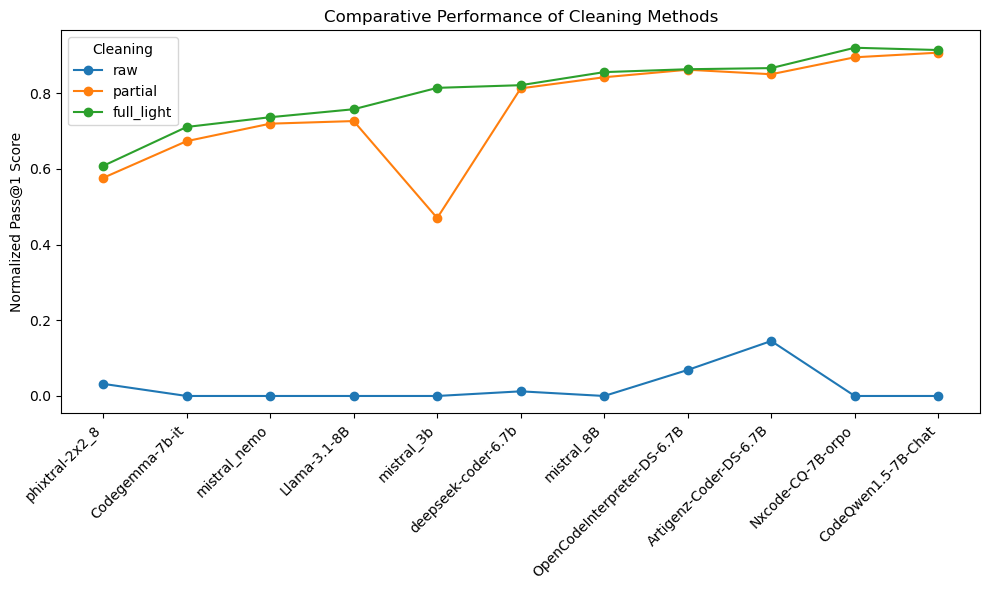

In [41]:
# visualize cleaning method performance
plot_df = final_df.drop(index='mean')
sorted_models = plot_df.index 
plt.figure(figsize=(10, 6))
for col in ['raw', 'partial', 'full_light']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Cleaning Methods')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

## 2.2 Select the best prompting strategy

In [42]:
# SELECT THE BEST PROMPTING STRATEGY

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full_light', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').mean()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]
final_prompt_df['best_prompt'] = final_prompt_df.idxmax(axis=1)
final_prompt_df['best_prompt2'] = final_prompt_df[prompt_order].idxmax(axis=1).map({name: i for i, name in enumerate(prompt_order)})
final_prompt_df = final_prompt_df.sort_values(by='basic_prompt')
final_prompt_df.loc['mean']       = final_prompt_df.mean(numeric_only=True)

print(final_prompt_df['best_prompt'].value_counts())
final_prompt_df

best_prompt
basic_prompt    5
prompt          4
full_prompt     2
Name: count, dtype: int64


prompt,basic_prompt,prompt,full_prompt,best_prompt,best_prompt2
phixtral-2x2_8,0.455268,0.726430,0.641143,prompt,1.000000
Llama-3.1-8B,0.694259,0.773417,0.803978,full_prompt,2.000000
Codegemma-7b-it,0.715775,0.676048,0.739355,full_prompt,2.000000
mistral_nemo,0.827337,0.721280,0.659763,basic_prompt,0.000000
deepseek-coder-6.7b,0.849502,0.811261,0.801356,basic_prompt,0.000000
mistral_3b,0.852293,0.806125,0.782597,basic_prompt,0.000000
OpenCodeInterpreter-DS-6.7B,0.861512,0.873908,0.853120,prompt,1.000000
Artigenz-Coder-DS-6.7B,0.888408,0.843952,0.865113,basic_prompt,0.000000
mistral_8B,0.901121,0.844242,0.820316,basic_prompt,0.000000
CodeQwen1.5-7B-Chat,0.905368,0.918243,0.917095,prompt,1.000000


In [43]:
# SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full_light', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').mean()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]

final_prompt_df['mean'] = final_prompt_df.mean(axis=1)
final_prompt_df = final_prompt_df.sort_values(by='mean', ascending=False)

final_prompt_df

prompt,basic_prompt,prompt,full_prompt,mean
Nxcode-CQ-7B-orpo,0.913519,0.943640,0.901585,0.919581
CodeQwen1.5-7B-Chat,0.905368,0.918243,0.917095,0.913568
Artigenz-Coder-DS-6.7B,0.888408,0.843952,0.865113,0.865824
OpenCodeInterpreter-DS-6.7B,0.861512,0.873908,0.853120,0.862847
mistral_8B,0.901121,0.844242,0.820316,0.855226
deepseek-coder-6.7b,0.849502,0.811261,0.801356,0.820706
mistral_3b,0.852293,0.806125,0.782597,0.813672
Llama-3.1-8B,0.694259,0.773417,0.803978,0.757218
mistral_nemo,0.827337,0.721280,0.659763,0.736127
Codegemma-7b-it,0.715775,0.676048,0.739355,0.710392


In [44]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Reflection basic_prompt raw               0.158646      0.000000   
                                  partial           0.338926      0.584107   
                                  full              0.367771      0.598529   
                                  full_light        0.346138      0.584107   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.656219      0.677853   
                                  full              0.677853      0.843999   
                                  full_light        0.685064      0.843999   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.627374      0.656219   
                                  full              0.641797      0.656219   
                                  full_light        0.641797      0.656219   
BigCode_Reflection   basic_prompt raw               0.144509      0.000000   
                                  partial           0.329480      0.786127   
                                  full              0.647399      0.838150   
                                  full_light        0.433526      0.780347   
                     prompt       raw               0.005780      0.000000   
                                  partial           0.878613      0.647399   
                                  full              0.907514      0.803468   
                                  full_light        0.884393      0.676301   
                     full_prompt  raw               0.011561      0.000000   
                                  partial           0.722543      0.968208   
                                  full              0.872832      0.968208   
                                  full_light        0.786127      0.968208   
MBPP_Reflection      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Reflection basic_prompt raw                0.000000   
                                  partial            0.656219   
                                  full               0.656219   
                                  full_light         0.750830   
                     prompt       raw                0.000000   
                                  partial            0.569685   
                                  full               0.605741   
                                  full_light         0.605741   
                     full_prompt  raw                0.000000   
                                  partial            0.641797   
                                  full               0.641797   
                                  full_light         0.641797   
BigCode_Reflection   basic_prompt raw                0.000000   
                                  partial            0.890173   
                                  full               0.890173   
                                  full_light         0.890173   
                     prompt       raw                0.000000   
                                  partial            0.919075   
                                  full               0.913295   
                                  full_light         0.913295   
                     full_prompt  raw                0.000000   
                                  partial            0.953757   
                                  full               0.953757   
                                  full_light         0.953757   
MBPP_Reflection      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Reflection basic_prompt raw        

In [22]:
# sanity check - view intermediate dataframes used in the above code
full_cleaned.head(25)

phixtral-2x2_8  phixtral-4x2_8  Solar-10.7B  \
dataset   prompt                                                      
HumanEval basic_prompt        0.608696        0.608696     0.536232   
          prompt              0.659420        0.659420     0.528986   
          full_prompt         0.652174        0.652174     0.492754   
BigCode   basic_prompt        0.596774        0.602151     0.709677   
          prompt              0.736559        0.736559     0.736559   
          full_prompt         0.612903        0.612903     0.709677   
MBPP      basic_prompt        0.648649        0.648649     0.605405   
          prompt              0.672973        0.672973     0.581081   
          full_prompt         0.645946        0.645946     0.537838   
LBPP      basic_prompt        0.562500        0.562500     0.395833   
          prompt              0.562500        0.562500     0.333333   
          full_prompt         0.500000        0.500000     0.333333   

                        Llama-3.1-8B  Codegemma-7b-it  deepseek-coder-6.7b  \
dataset   prompt                                                             
HumanEval basic_prompt      0.840580         0.724638             0.927536   
          prompt            0.811594         0.695652             0.963768   
          full_prompt       0.695652         0.644928             0.862319   
BigCode   basic_prompt      0.666667         0.720430             0.747312   
          prompt            0.650538         0.752688             0.801075   
          full_prompt       0.801075         0.666667             0.752688   
MBPP      basic_prompt      0.816216         0.721622             0.870270   
          prompt            0.762162         0.721622             0.829730   
          full_prompt       0.821622         0.713514             0.851351   
LBPP      basic_prompt      0.958333         0.625000             0.791667   
          prompt            0.625000         0.687500             0.770833   
          full_prompt       0.875000         0.750000             0.791667   

                        OpenCodeInterpreter-DS-6.7B  Artigenz-Coder-DS-6.7B  \
dataset   prompt                                                              
HumanEval basic_prompt                     0.905797                0.891304   
          prompt                           0.905797                0.905797   
          full_prompt                      0.855072                0.826087   
BigCode   basic_prompt                     0.677419                0.763441   
          prompt                           0.779570                0.747312   
          full_prompt                      0.564516                0.634409   
MBPP      basic_prompt                     0.851351                0.875676   
          prompt                           0.862162                0.824324   
          full_prompt                      0.859459                0.837838   
LBPP      basic_prompt                     0.958333                0.979167   
          prompt                           0.833333                0.958333   
          full_prompt                      0.854167                0.895833   

                        CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  mistral_7b  \
dataset   prompt                                                             
HumanEval basic_prompt             0.978261           0.985507    0.500000   
          prompt                   1.000000           0.985507    0.427536   
          full_prompt              0.927536           0.920290    0.442029   
BigCode   basic_prompt             0.779570           0.752688    0.870968   
          prompt                   0.784946           0.774194    0.881720   
          full_prompt              0.559140           0.548387    0.865591   
MBPP      basic_prompt             0.991892           0.986486    0.570270   
          prompt                   0.991892           1.000000    0.500000   
          full_prompt              0.972973      

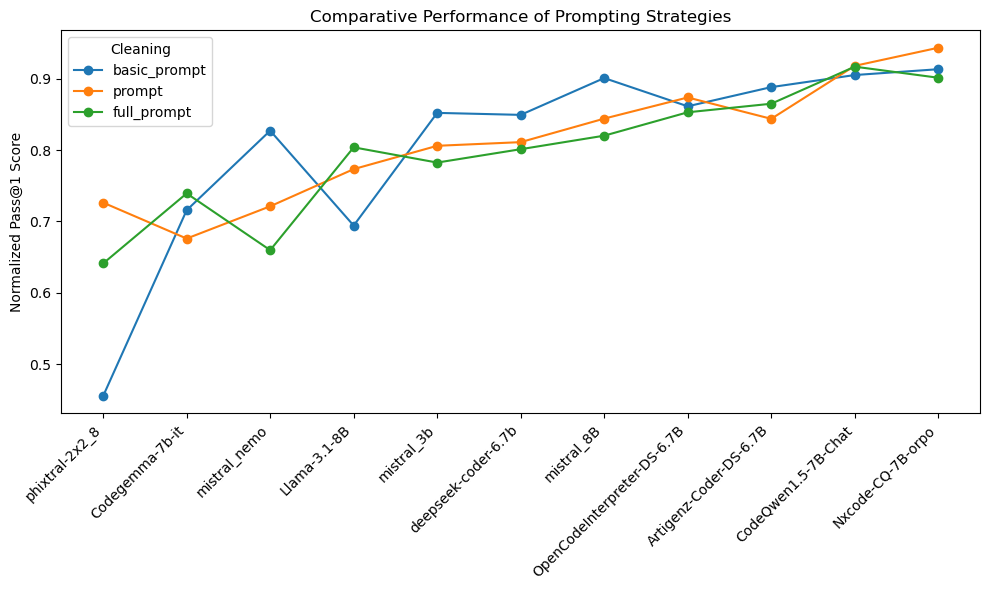

In [45]:
# visualize prompting strategy performance
plot_df = final_prompt_df.sort_values(by='mean')
sorted_models = plot_df.index
plt.figure(figsize=(10, 6))
for col in ['basic_prompt', 'prompt', 'full_prompt']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Prompting Strategies')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

In [46]:
# averaging across prompts and datasets
full_cleaned = combined.xs('full', level='cleaning')  # Index: (dataset, prompt), Columns: models

# Step 2: Compute mean score for each (dataset, prompt) pair — across models
mean_by_prompt_dataset = full_cleaned.mean(axis=1).unstack(level='dataset')  # Rows: prompt, Columns: datasets

# Step 3: Add "Mean" column (mean across datasets for each prompt)
mean_by_prompt_dataset['Mean'] = mean_by_prompt_dataset.mean(axis=1)

# Step 4: Reorder rows to ensure correct prompt order
prompt_order = ['basic_prompt', 'prompt', 'full_prompt']
mean_by_prompt_dataset = mean_by_prompt_dataset.loc[prompt_order]
mean_by_prompt_dataset.columns = sheet_names + ['Mean']
mean_by_prompt_dataset.loc['mean'] = mean_by_prompt_dataset.mean(numeric_only=True)

mean_by_prompt_dataset

,HumanEval_Reflection,BigCode_Reflection,MBPP_Reflection,LBPP_Reflection,Mean
prompt,,,,,
basic_prompt,0.794543,0.889911,0.777934,0.745165,0.801888
prompt,0.847444,0.901209,0.764656,0.705822,0.804783
full_prompt,0.800443,0.910667,0.773638,0.729591,0.803585
mean,0.814143,0.900596,0.772076,0.726859,0.803419


The lower average results for BigCode and LBPP confirm the data leakage (dataset contamination) effect. 

## 2.3 Rank Models on Pre-Agentic Data
__GETTING SLIGHTLY DIFFERENT RESULTS DEPENDING ON WHAT PROMPTING TECHNIQUE I CHOOSE. CONCLUSION - I NEED TO USE AVERAGE ACROSS ALL PROMPTS__

In [47]:
selected_prompt = 'basic_prompt'

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for the best prompt and cleaning
best_case_df = combined.loc[(slice(None), selected_prompt, 'full_light')]  # Index: (dataset)

# Step 2: Transpose so models are rows, datasets are columns
model_perf_df = best_case_df.T  # Rows = models, Columns = datasets

# Step 3: Add mean column
model_perf_df['mean'] = model_perf_df.mean(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)

# Optional: reorder columns
#model_perf_df = model_perf_df[['ds1', 'ds2', 'ds3', 'ds4', 'mean']]

# View result
model_perf_df

dataset,HumanEval_Reflection,BigCode_Reflection,MBPP_Reflection,LBPP_Reflection,mean
Nxcode-CQ-7B-orpo,0.981551,0.947977,1.000000,0.724550,0.913519
CodeQwen1.5-7B-Chat,0.966301,0.947977,0.982644,0.724550,0.905368
mistral_8B,0.908611,0.959538,0.753004,0.983331,0.901121
Artigenz-Coder-DS-6.7B,0.872555,0.867052,0.838451,0.975573,0.888408
OpenCodeInterpreter-DS-6.7B,0.843710,0.774566,0.827770,1.000000,0.861512
mistral_3b,0.894189,0.953757,0.699599,0.861627,0.852293
deepseek-coder-6.7b,0.836499,0.820809,0.886515,0.854185,0.849502
mistral_nemo,0.807654,0.907514,0.720961,0.873219,0.827337
Codegemma-7b-it,0.750830,0.890173,0.654206,0.567890,0.715775
Llama-3.1-8B,0.584107,0.780347,0.590120,0.822462,0.694259


In [48]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Reflection basic_prompt raw               0.158646      0.000000   
                                  partial           0.338926      0.584107   
                                  full              0.367771      0.598529   
                                  full_light        0.346138      0.584107   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.656219      0.677853   
                                  full              0.677853      0.843999   
                                  full_light        0.685064      0.843999   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.627374      0.656219   
                                  full              0.641797      0.656219   
                                  full_light        0.641797      0.656219   
BigCode_Reflection   basic_prompt raw               0.144509      0.000000   
                                  partial           0.329480      0.786127   
                                  full              0.647399      0.838150   
                                  full_light        0.433526      0.780347   
                     prompt       raw               0.005780      0.000000   
                                  partial           0.878613      0.647399   
                                  full              0.907514      0.803468   
                                  full_light        0.884393      0.676301   
                     full_prompt  raw               0.011561      0.000000   
                                  partial           0.722543      0.968208   
                                  full              0.872832      0.968208   
                                  full_light        0.786127      0.968208   
MBPP_Reflection      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Reflection basic_prompt raw                0.000000   
                                  partial            0.656219   
                                  full               0.656219   
                                  full_light         0.750830   
                     prompt       raw                0.000000   
                                  partial            0.569685   
                                  full               0.605741   
                                  full_light         0.605741   
                     full_prompt  raw                0.000000   
                                  partial            0.641797   
                                  full               0.641797   
                                  full_light         0.641797   
BigCode_Reflection   basic_prompt raw                0.000000   
                                  partial            0.890173   
                                  full               0.890173   
                                  full_light         0.890173   
                     prompt       raw                0.000000   
                                  partial            0.919075   
                                  full               0.913295   
                                  full_light         0.913295   
                     full_prompt  raw                0.000000   
                                  partial            0.953757   
                                  full               0.953757   
                                  full_light         0.953757   
MBPP_Reflection      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Reflection basic_prompt raw        

In [49]:
best_case_df

,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
dataset,,,,,,,,,,,
HumanEval_Reflection,0.346138,0.584107,0.750830,0.836499,0.843710,0.872555,0.966301,0.981551,0.894189,0.908611,0.807654
BigCode_Reflection,0.433526,0.780347,0.890173,0.820809,0.774566,0.867052,0.947977,0.947977,0.953757,0.959538,0.907514
MBPP_Reflection,0.571429,0.590120,0.654206,0.886515,0.827770,0.838451,0.982644,1.000000,0.699599,0.753004,0.720961
LBPP_Reflection,0.469978,0.822462,0.567890,0.854185,1.000000,0.975573,0.724550,0.724550,0.861627,0.983331,0.873219


## Average across all prompts
This gives me the same results as in the above cell that says this at the top: SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

In [66]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for cleaning == 'full' only
full_cleaned = combined.xs('full_light', level='cleaning')

# Step 2: Average across all prompts within each dataset
avg_by_dataset = full_cleaned.groupby('dataset').mean()

# Step 3: Transpose so models are rows, datasets are columns
model_perf_df = avg_by_dataset.T  # Rows = models, Columns = datasets

# Step 4: Add mean column
model_perf_df['mean'] = model_perf_df.mean(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)
model_perf_df.loc['mean'] = model_perf_df.mean()

# View result
model_perf_df

dataset,BigCode_Reflection,HumanEval_Reflection,LBPP_Reflection,MBPP_Reflection,mean
Nxcode-CQ-7B-orpo,0.946050,0.973788,0.785190,0.973298,0.919581
CodeQwen1.5-7B-Chat,0.949904,0.982341,0.757187,0.964842,0.913568
Artigenz-Coder-DS-6.7B,0.867052,0.871537,0.899609,0.825100,0.865824
OpenCodeInterpreter-DS-6.7B,0.870906,0.860536,0.888169,0.831776,0.862847
mistral_8B,0.947977,0.901400,0.823865,0.747664,0.855226
deepseek-coder-6.7b,0.849711,0.877636,0.767762,0.787717,0.820706
mistral_3b,0.944123,0.889381,0.737605,0.683578,0.813672
Llama-3.1-8B,0.808285,0.694775,0.839564,0.686248,0.757218
mistral_nemo,0.705202,0.742753,0.787161,0.709390,0.736127
Codegemma-7b-it,0.919075,0.666122,0.584810,0.671562,0.710392


In [67]:
0.805707 - 0.748568

0.05713899999999994

# PART 3. Select Best Cleaning Method, Best Prompting Strategy, and Rank SLMs Using Mean Values

## 3.1 Select the best cleaning method

### 3.1.1 Approach 1

In [51]:
# get mean values for each cleaning method and compare them with raw - the method with the largest diff wins
for key in res:
    df = res[key].copy()
    mean_scores = df.mean(axis=1).unstack(level=1)
    mean_scores.loc['mean'] = mean_scores.max()
    max_col = mean_scores.loc['mean'].idxmax()
    print(f'Dataset: {key}\n')
    print(f"Cleaning method with the highest mean score: {max_col}")
    
    # Difference with raw
    full_value = mean_scores.loc['mean', 'full']
    full_light = mean_scores.loc['mean', 'full_light']
    raw_value  = mean_scores.loc['mean', 'raw']
    print(f"Difference between full and raw:       {full_value - raw_value:.5f}")
    print(f"Difference between full_light and raw: {full_light - raw_value:.5f}")
    print(f"Overall difference:                    {(full_value - raw_value)-(full_light-raw_value):.5f}\n")
    print(mean_scores)
    print('\n', '='*77, '\n', sep='')

Dataset: HumanEval_Reflection

Cleaning method with the highest mean score: full_light
Difference between full and raw:       0.73600
Difference between full_light and raw: 0.74761
Overall difference:                    -0.01161

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.794543    0.799286  0.789954  0.111446
full_prompt   0.800443    0.801099  0.735909  0.017700
prompt        0.847444    0.859053  0.740131  0.015078
mean          0.847444    0.859053  0.789954  0.111446


Dataset: BigCode_Reflection

Cleaning method with the highest mean score: full
Difference between full and raw:       0.80347
Difference between full_light and raw: 0.78586
Overall difference:                    0.01760

cleaning          full  full_light   partial       raw
prompt                                                
basic_prompt  0.889911    0.843931  0.841040  0.107199
full_prompt   0.910667    0.893064  0.867840  0.0052

In [52]:
full = (0.47053+0.62294+0.76505+0.70694)
full_light = (0.47246+0.59140+0.76216+0.73611)
print(f'Full cleaning:       {full}\nFull light cleaning: {full_light}')

Full cleaning:       2.56546
Full light cleaning: 2.56213


__The full cleaning method wins__ because it has the largest overall difference with the raw cleaning results across all the prompts and all the datasets, but the difference is minimal.

### 3.1.2 Approach 2

In [53]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Average across prompts for each (dataset, cleaning, model)
avg_across_prompts = combined.groupby(['dataset', 'cleaning']).max()

# Step 2: Average across datasets for each (cleaning, model)
avg_across_all = avg_across_prompts.groupby('cleaning').mean()

# Step 3: Transpose to get models as rows
final_df = avg_across_all.T

# Step 4: sort columns if needed
cleaning_order = ['raw', 'partial', 'full', 'full_light']
final_df = final_df[cleaning_order]
final_df['best_cleaning'] = final_df.idxmax(axis=1)
final_df['best_cleaning2'] = final_df[cleaning_order].idxmax(axis=1).map({name: i for i, name in enumerate(cleaning_order)})
final_df = final_df.sort_values(by='full')
final_df.loc['mean'] = final_df.mean(numeric_only=True)

print(final_df['best_cleaning'].value_counts())
final_df

best_cleaning
full_light    9
partial       1
full          1
Name: count, dtype: int64


cleaning,raw,partial,full,full_light,best_cleaning,best_cleaning2
phixtral-2x2_8,0.091811,0.696130,0.708764,0.726430,full_light,3.000000
Codegemma-7b-it,0.000000,0.705793,0.730271,0.774290,full_light,3.000000
mistral_nemo,0.000000,0.815316,0.821148,0.828005,full_light,3.000000
mistral_3b,0.000000,0.852293,0.826279,0.852293,partial,1.000000
Llama-3.1-8B,0.000000,0.813838,0.855819,0.893123,full_light,3.000000
mistral_8B,0.000000,0.903121,0.871901,0.913273,full_light,3.000000
deepseek-coder-6.7b,0.036786,0.886932,0.879453,0.912504,full_light,3.000000
OpenCodeInterpreter-DS-6.7B,0.206164,0.914259,0.907491,0.916085,full_light,3.000000
Artigenz-Coder-DS-6.7B,0.312130,0.887614,0.911652,0.912912,full_light,3.000000
Nxcode-CQ-7B-orpo,0.000000,0.917537,0.946728,0.954104,full_light,3.000000


__Partial wins when aggregating by max() both time__.  
__Full wins when doing max() first time and mean() the second gtime in the code above__

In [54]:
# sanity check - view all intermediate dataframes used above
avg_across_prompts.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              cleaning                                   
BigCode_Reflection   full              0.907514      0.968208   
                     full_light        0.884393      0.968208   
                     partial           0.878613      0.968208   
                     raw               0.144509      0.000000   
HumanEval_Reflection full              0.677853      0.843999   
                     full_light        0.685064      0.843999   
                     partial           0.656219      0.677853   
                     raw               0.158646      0.000000   
LBPP_Reflection      full              0.587473      0.783297   
                     full_light        0.674048      0.932515   
                     partial           0.587473      0.861627   
                     raw               0.058747      0.000000   
MBPP_Reflection      full              0.662216      0.827770   
                     full_light        0.662216      0.827770   
                     partial           0.662216      0.747664   
                     raw               0.005340      0.000000   

                                 Codegemma-7b-it  deepseek-coder-6.7b  \
dataset              cleaning                                           
BigCode_Reflection   full               0.953757             0.942197   
                     full_light         0.953757             0.942197   
                     partial            0.953757             1.000000   
                     raw                0.000000             0.017341   
HumanEval_Reflection full               0.656219             0.923033   
                     full_light         0.750830             0.967120   
                     partial            0.656219             0.930245   
                     raw                0.000000             0.129802   
LBPP_Reflection      full               0.646220             0.854185   
                     full_light         0.696978             0.854185   
                     partial            0.548308             0.824427   
                     raw                0.000000             0.000000   
MBPP_Reflection      full               0.664887             0.798398   
                     full_light         0.695594             0.886515   
                     partial            0.664887             0.793057   
                     raw                0.000000             0.000000   

                                 OpenCodeInterpreter-DS-6.7B  \
dataset              cleaning                                  
BigCode_Reflection   full                           0.968208   
                     full_light                     0.930636   
                     partial                        0.947977   
                     raw                            0.300578   
HumanEval_Reflection full                           0.872555   
                     full_light                     0.872555   
                     partial                        0.919861   
                     raw                            0.411038   
LBPP_Reflection      full                           0.958759   
                     full_light                     1.000000   
                     partial                        0.958759   
                     raw                            0.019582   
MBPP_Reflection      full                           0.830441   
                     full_light                     0.861148   
                     partial                        0.830441   
                     raw                            0.093458   

                                 Artigenz-Coder-DS-6.7B  CodeQwen1.5-7B-Chat  \
dataset              cleaning                                                  
BigCode_Reflection   full                      0.994220             0.953757   
                     full_light                0.924855             0.953757   
                     partial                   0.919075             0.9797

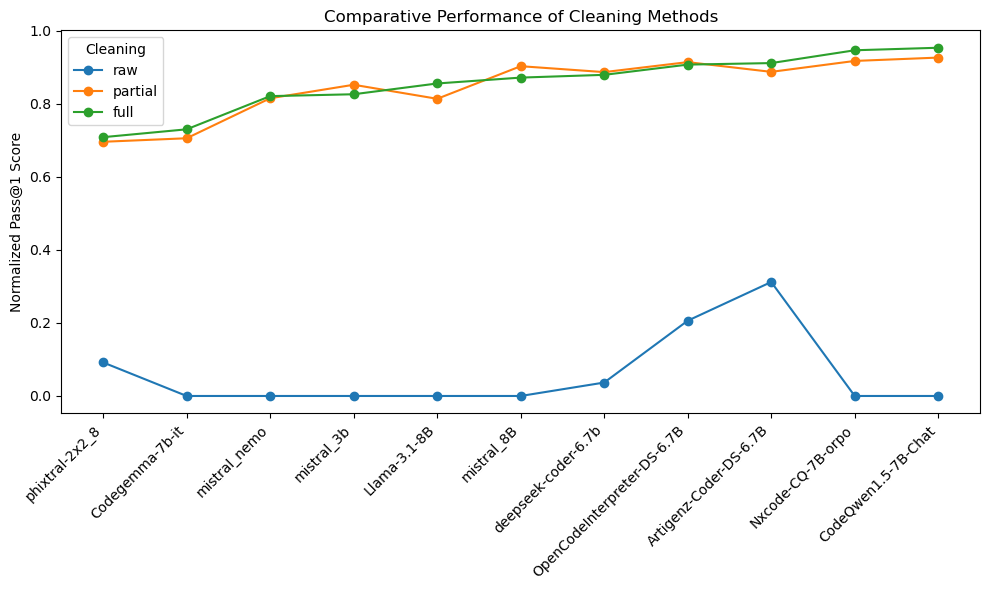

In [55]:
# visualize cleaning method performance
plot_df = final_df.drop(index='mean')
sorted_models = plot_df.index 
plt.figure(figsize=(10, 6))
for col in ['raw', 'partial', 'full']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Cleaning Methods')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

## 3.2 Select the best prompting strategy

In [56]:
# SELECT THE BEST PROMPTING STRATEGY

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').max()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]
final_prompt_df['best_prompt'] = final_prompt_df.idxmax(axis=1)
final_prompt_df['best_prompt2'] = final_prompt_df[prompt_order].idxmax(axis=1).map({name: i for i, name in enumerate(prompt_order)})
final_prompt_df = final_prompt_df.sort_values(by='basic_prompt')
final_prompt_df.loc['mean']       = final_prompt_df.mean(numeric_only=True)

print(final_prompt_df['best_prompt'].value_counts())
final_prompt_df

best_prompt
full_prompt     6
basic_prompt    4
prompt          1
Name: count, dtype: int64


prompt,basic_prompt,prompt,full_prompt,best_prompt,best_prompt2
phixtral-2x2_8,0.647399,0.907514,0.872832,prompt,1.000000
Llama-3.1-8B,0.838150,0.843999,0.968208,full_prompt,2.000000
Codegemma-7b-it,0.890173,0.913295,0.953757,full_prompt,2.000000
deepseek-coder-6.7b,0.890173,0.923033,0.942197,full_prompt,2.000000
Artigenz-Coder-DS-6.7B,0.901734,0.872832,0.994220,full_prompt,2.000000
mistral_nemo,0.945087,0.832370,0.724550,basic_prompt,0.000000
mistral_3b,0.947977,0.936416,0.953757,full_prompt,2.000000
OpenCodeInterpreter-DS-6.7B,0.958759,0.924855,0.968208,full_prompt,2.000000
mistral_8B,0.959538,0.956609,0.942197,basic_prompt,0.000000
CodeQwen1.5-7B-Chat,0.982644,0.980723,0.980723,basic_prompt,0.000000


In [57]:
# SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter combined by the best cleaning method == 'full'
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across datasets for each prompt and model
avg_by_prompt = full_cleaned.groupby('prompt').max()

# Step 3: Transpose so rows = models, columns = prompts
final_prompt_df = avg_by_prompt.T

# Step 4: Reorder prompt columns if needed
prompt_order    = ['basic_prompt', 'prompt', 'full_prompt']
final_prompt_df = final_prompt_df[prompt_order]

final_prompt_df['mean'] = final_prompt_df.mean(axis=1)
final_prompt_df = final_prompt_df.sort_values(by='mean', ascending=False)

final_prompt_df

prompt,basic_prompt,prompt,full_prompt,mean
CodeQwen1.5-7B-Chat,0.982644,0.980723,0.980723,0.981363
Nxcode-CQ-7B-orpo,0.987934,0.973512,0.966301,0.975916
mistral_8B,0.959538,0.956609,0.942197,0.952781
OpenCodeInterpreter-DS-6.7B,0.958759,0.924855,0.968208,0.950608
mistral_3b,0.947977,0.936416,0.953757,0.946050
Artigenz-Coder-DS-6.7B,0.901734,0.872832,0.994220,0.922929
Codegemma-7b-it,0.890173,0.913295,0.953757,0.919075
deepseek-coder-6.7b,0.890173,0.923033,0.942197,0.918468
Llama-3.1-8B,0.838150,0.843999,0.968208,0.883452
mistral_nemo,0.945087,0.832370,0.724550,0.834002


In [58]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Reflection basic_prompt raw               0.158646      0.000000   
                                  partial           0.338926      0.584107   
                                  full              0.367771      0.598529   
                                  full_light        0.346138      0.584107   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.656219      0.677853   
                                  full              0.677853      0.843999   
                                  full_light        0.685064      0.843999   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.627374      0.656219   
                                  full              0.641797      0.656219   
                                  full_light        0.641797      0.656219   
BigCode_Reflection   basic_prompt raw               0.144509      0.000000   
                                  partial           0.329480      0.786127   
                                  full              0.647399      0.838150   
                                  full_light        0.433526      0.780347   
                     prompt       raw               0.005780      0.000000   
                                  partial           0.878613      0.647399   
                                  full              0.907514      0.803468   
                                  full_light        0.884393      0.676301   
                     full_prompt  raw               0.011561      0.000000   
                                  partial           0.722543      0.968208   
                                  full              0.872832      0.968208   
                                  full_light        0.786127      0.968208   
MBPP_Reflection      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Reflection basic_prompt raw                0.000000   
                                  partial            0.656219   
                                  full               0.656219   
                                  full_light         0.750830   
                     prompt       raw                0.000000   
                                  partial            0.569685   
                                  full               0.605741   
                                  full_light         0.605741   
                     full_prompt  raw                0.000000   
                                  partial            0.641797   
                                  full               0.641797   
                                  full_light         0.641797   
BigCode_Reflection   basic_prompt raw                0.000000   
                                  partial            0.890173   
                                  full               0.890173   
                                  full_light         0.890173   
                     prompt       raw                0.000000   
                                  partial            0.919075   
                                  full               0.913295   
                                  full_light         0.913295   
                     full_prompt  raw                0.000000   
                                  partial            0.953757   
                                  full               0.953757   
                                  full_light         0.953757   
MBPP_Reflection      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Reflection basic_prompt raw        

In [59]:
# sanity check - view intermediate dataframes used in the above code
full_cleaned.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt                                       
HumanEval_Reflection basic_prompt        0.367771      0.598529   
                     prompt              0.677853      0.843999   
                     full_prompt         0.641797      0.656219   
BigCode_Reflection   basic_prompt        0.647399      0.838150   
                     prompt              0.907514      0.803468   
                     full_prompt         0.872832      0.968208   
MBPP_Reflection      basic_prompt        0.571429      0.574099   
                     prompt              0.662216      0.643525   
                     full_prompt         0.627503      0.827770   
LBPP_Reflection      basic_prompt        0.450396      0.783297   
                     prompt              0.587473      0.744132   
                     full_prompt         0.489561      0.763715   

                                   Codegemma-7b-it  deepseek-coder-6.7b  \
dataset              prompt                                               
HumanEval_Reflection basic_prompt         0.656219             0.829288   
                     prompt               0.605741             0.923033   
                     full_prompt          0.641797             0.829288   
BigCode_Reflection   basic_prompt         0.890173             0.890173   
                     prompt               0.913295             0.872832   
                     full_prompt          0.953757             0.942197   
MBPP_Reflection      basic_prompt         0.659546             0.798398   
                     prompt               0.656876             0.747664   
                     full_prompt          0.664887             0.728972   
LBPP_Reflection      basic_prompt         0.528725             0.854185   
                     prompt               0.430813             0.724550   
                     full_prompt          0.646220             0.704967   

                                   OpenCodeInterpreter-DS-6.7B  \
dataset              prompt                                      
HumanEval_Reflection basic_prompt                     0.850921   
                     prompt                           0.858133   
                     full_prompt                      0.872555   
BigCode_Reflection   basic_prompt                     0.867052   
                     prompt                           0.924855   
                     full_prompt                      0.968208   
MBPP_Reflection      basic_prompt                     0.830441   
                     prompt                           0.830441   
                     full_prompt                      0.806409   
LBPP_Reflection      basic_prompt                     0.958759   
                     prompt                           0.842044   
                     full_prompt                      0.802879   

                                   Artigenz-Coder-DS-6.7B  \
dataset              prompt                                 
HumanEval_Reflection basic_prompt                0.879766   
                     prompt                      0.858133   
                     full_prompt                 0.822077   
BigCode_Reflection   basic_prompt                0.901734   
                     prompt                      0.872832   
                     full_prompt                 0.994220   
MBPP_Reflection      basic_prompt                0.871829   
                     prompt                      0.811749   
                     full_prompt                 0.830441   
LBPP_Reflection      basic_prompt                0.900792   
                     prompt                      0.842044   
                     full_prompt                 0.861627   

                                   CodeQwen1.5-7B-Chat  Nxcode-CQ-7B-orpo  \
dataset              prompt                                                 
HumanEval_Reflection basic_prompt             0.973512           0.987934   
                     prompt       

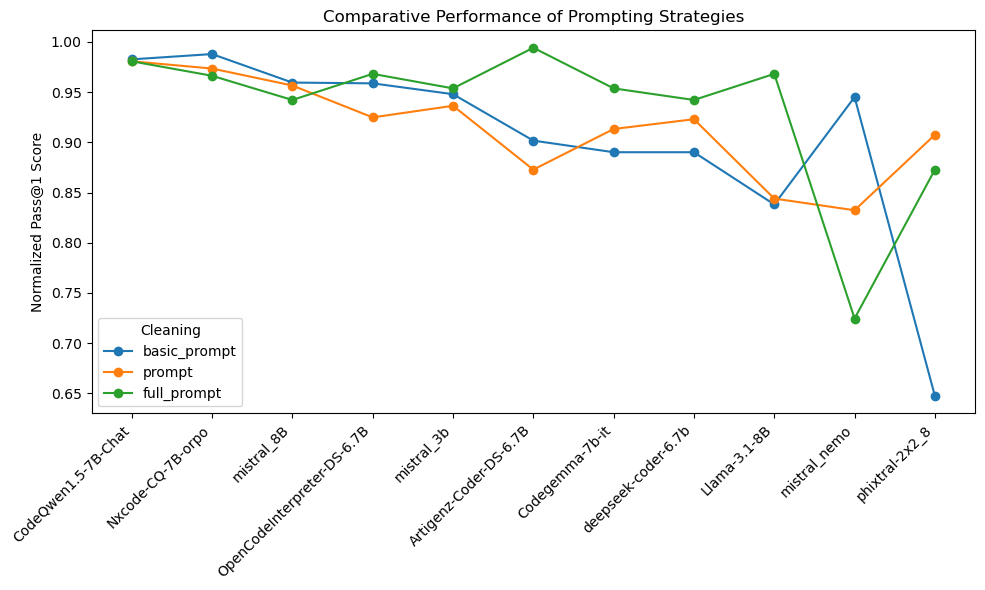

In [60]:
# visualize prompting strategy performance
plot_df = final_prompt_df
sorted_models = plot_df.index
plt.figure(figsize=(10, 6))
for col in ['basic_prompt', 'prompt', 'full_prompt']:
    y = plot_df[col]
    plt.plot(range(len(sorted_models)), y, marker='o', label=col)
plt.title('Comparative Performance of Prompting Strategies')
plt.xticks(range(len(sorted_models)), labels=sorted_models, rotation=45, ha='right')
plt.ylabel('Normalized Pass@1 Score')
plt.legend(title='Cleaning')
plt.tight_layout()
plt.show()

In [61]:
# averaging across prompts and datasets
full_cleaned = combined.xs('full', level='cleaning')  # Index: (dataset, prompt), Columns: models

# Step 2: Compute mean score for each (dataset, prompt) pair — across models
mean_by_prompt_dataset = full_cleaned.mean(axis=1).unstack(level='dataset')  # Rows: prompt, Columns: datasets

# Step 3: Add "Mean" column (mean across datasets for each prompt)
mean_by_prompt_dataset['Mean'] = mean_by_prompt_dataset.max(axis=1)

# Step 4: Reorder rows to ensure correct prompt order
prompt_order = ['basic_prompt', 'prompt', 'full_prompt']
mean_by_prompt_dataset = mean_by_prompt_dataset.loc[prompt_order]
mean_by_prompt_dataset.columns = sheet_names + ['Mean']
mean_by_prompt_dataset.loc['mean'] = mean_by_prompt_dataset.mean(numeric_only=True)

mean_by_prompt_dataset

,HumanEval_Reflection,BigCode_Reflection,MBPP_Reflection,LBPP_Reflection,Mean
prompt,,,,,
basic_prompt,0.794543,0.889911,0.777934,0.745165,0.889911
prompt,0.847444,0.901209,0.764656,0.705822,0.901209
full_prompt,0.800443,0.910667,0.773638,0.729591,0.910667
mean,0.814143,0.900596,0.772076,0.726859,0.900596


The lower average results for BigCode and LBPP confirm the data leakage (dataset contamination) effect. 

## 3.3 Rank Models on Pre-Agentic Data
__GETTING SLIGHTLY DIFFERENT RESULTS DEPENDING ON WHAT PROMPTING TECHNIQUE I CHOOSE. CONCLUSION - I NEED TO USE AVERAGE ACROSS ALL PROMPTS__

In [62]:
selected_prompt = 'basic_prompt'

# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for the best prompt and cleaning
best_case_df = combined.loc[(slice(None), selected_prompt, 'full')]  # Index: (dataset)

# Step 2: Transpose so models are rows, datasets are columns
model_perf_df = best_case_df.T  # Rows = models, Columns = datasets

# Step 3: Add mean column
model_perf_df['mean'] = model_perf_df.max(axis=1)
model_perf_df = model_perf_df.sort_values(by='mean', ascending=False)

# Optional: reorder columns
#model_perf_df = model_perf_df[['ds1', 'ds2', 'ds3', 'ds4', 'mean']]

# View result
model_perf_df

dataset,HumanEval_Reflection,BigCode_Reflection,MBPP_Reflection,LBPP_Reflection,mean
Nxcode-CQ-7B-orpo,0.987934,0.947977,0.979973,0.724550,0.987934
CodeQwen1.5-7B-Chat,0.973512,0.953757,0.982644,0.724550,0.982644
mistral_8B,0.901400,0.959538,0.807744,0.763715,0.959538
OpenCodeInterpreter-DS-6.7B,0.850921,0.867052,0.830441,0.958759,0.958759
mistral_3b,0.886977,0.947977,0.752203,0.704967,0.947977
mistral_nemo,0.807654,0.945087,0.728972,0.802879,0.945087
Artigenz-Coder-DS-6.7B,0.879766,0.901734,0.871829,0.900792,0.901734
Codegemma-7b-it,0.656219,0.890173,0.659546,0.528725,0.890173
deepseek-coder-6.7b,0.829288,0.890173,0.798398,0.854185,0.890173
Llama-3.1-8B,0.598529,0.838150,0.574099,0.783297,0.838150


In [63]:
combined.head(25)

phixtral-2x2_8  Llama-3.1-8B  \
dataset              prompt       cleaning                                   
HumanEval_Reflection basic_prompt raw               0.158646      0.000000   
                                  partial           0.338926      0.584107   
                                  full              0.367771      0.598529   
                                  full_light        0.346138      0.584107   
                     prompt       raw               0.000000      0.000000   
                                  partial           0.656219      0.677853   
                                  full              0.677853      0.843999   
                                  full_light        0.685064      0.843999   
                     full_prompt  raw               0.000000      0.000000   
                                  partial           0.627374      0.656219   
                                  full              0.641797      0.656219   
                                  full_light        0.641797      0.656219   
BigCode_Reflection   basic_prompt raw               0.144509      0.000000   
                                  partial           0.329480      0.786127   
                                  full              0.647399      0.838150   
                                  full_light        0.433526      0.780347   
                     prompt       raw               0.005780      0.000000   
                                  partial           0.878613      0.647399   
                                  full              0.907514      0.803468   
                                  full_light        0.884393      0.676301   
                     full_prompt  raw               0.011561      0.000000   
                                  partial           0.722543      0.968208   
                                  full              0.872832      0.968208   
                                  full_light        0.786127      0.968208   
MBPP_Reflection      basic_prompt raw               0.000000      0.000000   

                                              Codegemma-7b-it  \
dataset              prompt       cleaning                      
HumanEval_Reflection basic_prompt raw                0.000000   
                                  partial            0.656219   
                                  full               0.656219   
                                  full_light         0.750830   
                     prompt       raw                0.000000   
                                  partial            0.569685   
                                  full               0.605741   
                                  full_light         0.605741   
                     full_prompt  raw                0.000000   
                                  partial            0.641797   
                                  full               0.641797   
                                  full_light         0.641797   
BigCode_Reflection   basic_prompt raw                0.000000   
                                  partial            0.890173   
                                  full               0.890173   
                                  full_light         0.890173   
                     prompt       raw                0.000000   
                                  partial            0.919075   
                                  full               0.913295   
                                  full_light         0.913295   
                     full_prompt  raw                0.000000   
                                  partial            0.953757   
                                  full               0.953757   
                                  full_light         0.953757   
MBPP_Reflection      basic_prompt raw                0.000000   

                                              deepseek-coder-6.7b  \
dataset              prompt       cleaning                          
HumanEval_Reflection basic_prompt raw        

In [64]:
best_case_df

,phixtral-2x2_8,Llama-3.1-8B,Codegemma-7b-it,deepseek-coder-6.7b,OpenCodeInterpreter-DS-6.7B,Artigenz-Coder-DS-6.7B,CodeQwen1.5-7B-Chat,Nxcode-CQ-7B-orpo,mistral_3b,mistral_8B,mistral_nemo
dataset,,,,,,,,,,,
HumanEval_Reflection,0.367771,0.598529,0.656219,0.829288,0.850921,0.879766,0.973512,0.987934,0.886977,0.901400,0.807654
BigCode_Reflection,0.647399,0.838150,0.890173,0.890173,0.867052,0.901734,0.953757,0.947977,0.947977,0.959538,0.945087
MBPP_Reflection,0.571429,0.574099,0.659546,0.798398,0.830441,0.871829,0.982644,0.979973,0.752203,0.807744,0.728972
LBPP_Reflection,0.450396,0.783297,0.528725,0.854185,0.958759,0.900792,0.724550,0.724550,0.704967,0.763715,0.802879


## Get Max Across All Prompts
This gives me the same results as in the above cell that says this at the top: SAME CODE AS IN THE PREVIOUS CELL, BUT CURTAILED TO RANK THE MODEL BY AVERAGE ACROSS ALL PROMPTS

In [69]:
# aggregate by model
all_dfs  = list(res.values())
combined = pd.concat(all_dfs, keys=sheet_names, names=['dataset', 'prompt', 'cleaning'])

# Step 1: Filter for cleaning == 'full' only
full_cleaned = combined.xs('full', level='cleaning')

# Step 2: Average across all prompts within each dataset
avg_by_dataset = full_cleaned.groupby('dataset').max()

# Step 3: Transpose so models are rows, datasets are columns
model_perf_df = avg_by_dataset.T  # Rows = models, Columns = datasets

# Step 4: Add mean column
model_perf_df['Max'] = model_perf_df.max(axis=1)
model_perf_df = model_perf_df.sort_values(by='Max', ascending=False)
model_perf_df.loc['mean'] = model_perf_df.mean()

# View result
model_perf_df

dataset,BigCode_Reflection,HumanEval_Reflection,LBPP_Reflection,MBPP_Reflection,Max
Artigenz-Coder-DS-6.7B,0.994220,0.879766,0.900792,0.871829,0.994220
Nxcode-CQ-7B-orpo,0.947977,0.987934,0.871026,0.979973,0.987934
CodeQwen1.5-7B-Chat,0.953757,0.980723,0.897502,0.982644,0.982644
Llama-3.1-8B,0.968208,0.843999,0.783297,0.827770,0.968208
OpenCodeInterpreter-DS-6.7B,0.968208,0.872555,0.958759,0.830441,0.968208
mistral_8B,0.959538,0.956609,0.763715,0.807744,0.959538
Codegemma-7b-it,0.953757,0.656219,0.646220,0.664887,0.953757
mistral_3b,0.953757,0.894189,0.704967,0.752203,0.953757
mistral_nemo,0.945087,0.807654,0.802879,0.728972,0.945087
deepseek-coder-6.7b,0.942197,0.923033,0.854185,0.798398,0.942197
